<a href="https://colab.research.google.com/github/PsorTheDoctor/Sekcja-SI/blob/master/computer_vision/tensorflow_hub/tf_hub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning z użyciem Tensorflow Hub

### Import bibliotek

In [1]:
%tensorflow_version 2.x
import numpy as np
import PIL.Image as Image
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import matplotlib.pyplot as plt
print(f'Tensorflow version: {tf.__version__}')
print(f'Tensorflow Hub version: {hub.__version__}')

TensorFlow 2.x selected.
Tensorflow version: 2.1.0-rc1
Tensorflow Hub version: 0.7.0


### Załadowanie modelu

In [0]:
classifier_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"

IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

### Załadowanie etykiet

In [4]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())
imagenet_labels

array(['background', 'tench', 'goldfish', ..., 'bolete', 'ear',
       'toilet tissue'], dtype='<U30')

### Załadowanie obrazu

In [15]:
from google.colab import files
uploaded = files.upload()

Saving notebook.jpg to notebook.jpg


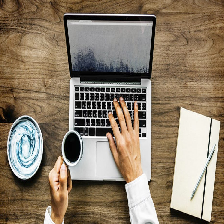

In [16]:
filename = list(uploaded.keys())[0]
img = Image.open(filename).resize(IMAGE_SHAPE)
img

### Predykcja na podstawie modelu

In [17]:
img_arr = np.array(img) / 255.
img_arr = np.expand_dims(img_arr, axis=0)
result = classifier.predict(img_arr)
predicted_class = np.argmax(result[0], axis=-1)
predicted_class_name = imagenet_labels[predicted_class]
predicted_class_name

'notebook'

### Wyświetlenie predykcji

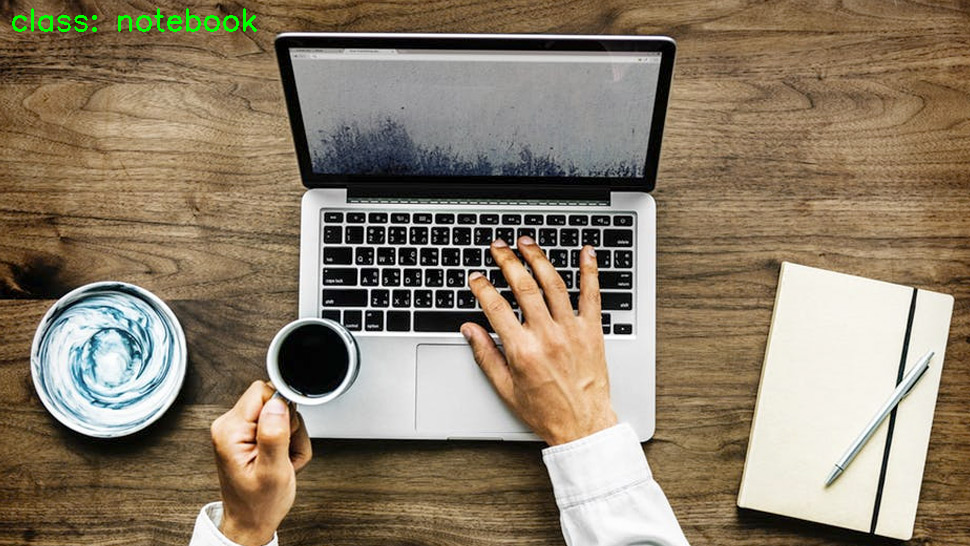

In [20]:
from google.colab.patches import cv2_imshow
import cv2

img = cv2.imread(filename)
text = f'class: {predicted_class_name}'
img = cv2.putText(img=img, text=text, org=(10, 30), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                  fontScale=1, color=(0, 255, 0), thickness=2)
cv2_imshow(img)